# Generate seamless textures with Stable Diffusion using in-painting

By [Travis Hoppe](https://twitter.com/metasemantic/status/1568450612924420096). This uses the CompVis SD [checkpoint](https://github.com/CompVis/stable-diffusion) provided by [HuggingFace](https://huggingface.co/CompVis/stable-diffusion-v1-4).


+ _Version 0.1.1 (bug fix from [@PhiMarHal](https://twitter.com/PhiMarHal/status/1569047664855240704))_
+ _Version 0.1.0 Initial release_

In [ ]:
# Check the GPU, this generally requires a 16 GB card
!nvidia-smi

Mon Sep 12 03:37:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install dependencies
! pip install --upgrade Pillow==9.0.0
! pip install --quiet torch numpy diffusers transformers ftfy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


If the above cell says "You must restart the runtime in order to use newly installed versions." click `Runtime` -> `Restart Runtime`. For the code to work, the version below must output 9.0.0

In [ ]:
from PIL import Image
Image.__version__

'9.0.0'

In [ ]:
# You'll need a login to access the model, do this here
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
# Load model
import torch
from diffusers import StableDiffusionInpaintPipeline
from transformers.trainer_utils import set_seed

# make sure you're logged in with `huggingface-cli login`
model_id = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_id, use_auth_token=True,
    torch_dtype=torch.float16, revision="fp16",).to("cuda")
pipe = pipe.to("cuda")

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

{'trained_betas'} was not found in config. Values will be initialized to default values.


In [ ]:
# Load model 2

from diffusers import StableDiffusionPipeline
pipe2 = StableDiffusionPipeline.from_pretrained(
    model_id, 
    set_auth_token=True,
    torch_dtype=torch.float16, revision="fp16",
)
pipe2 = pipe2.to("cuda")

{'trained_betas'} was not found in config. Values will be initialized to default values.


In [ ]:
# The code to get it to work 
import numpy as np
from PIL import Image

def circle_mask(img):
    """Roll the images 50% vertical and horz and mask the new center for in-fill"""
    w, h = img.size
    x = np.roll(np.roll(np.array(img), h // 2, 0), w // 2, 1)

    img2 = Image.fromarray(x)
    mask = Image.fromarray(np.zeros_like(x)[:, :, 0])

    draw = ImageDraw.Draw(mask)
    coords = [(w / 2, 0), (w, h / 2), (w / 2, h), (0, h / 2)]
    draw.polygon(coords, fill=255)

    return img2, mask

@torch.no_grad()
def seeded_random_latent(seed, in_channels=4, height=512, width=512):
    set_seed(seed)
    device = "cuda"
    batch_size = 1

    latents = torch.randn(
        (batch_size, in_channels, height // 8, width // 8),
        generator=None,
        device=device,
    )
    return latents

@torch.no_grad()
def generate(prompt, seed):
    width, height = 512, 512

    z0 = seeded_random_latent(seed)

    with torch.autocast("cuda"):
        img0 = pipe2(prompt, latents=z0, height=height, width=width)["sample"][0]

    return img0

@torch.no_grad()
def seamless_diffusion(prompt, seed, circle_strength=0.50, input_image=None):

    if input_image is None:
      img0 = generate(prompt, seed)
    else:
      img0 = input_image.resize((512, 512))
    img1, mask = circle_mask(img0)

    with torch.autocast("cuda"):
        img2 = pipe(
            prompt=prompt, init_image=img1, mask_image=mask, strength=circle_strength
        )["sample"][0]
    return img2

def combine_images_w(imgs):
    widths = [x.width for x in imgs]
    h = imgs[0].height

    img = Image.new("RGB", (sum(widths), h))
    img.paste(imgs[0], (0, 0))
    w = imgs[0].width

    for k in range(1, len(imgs)):
        img.paste(imgs[k], (w, 0))
        w += imgs[k - 1].width

    return img

def combine_images_h(imgs):
    heights = [x.height for x in imgs]
    w = imgs[0].width

    img = Image.new("RGB", (w, sum(heights)))

    img.paste(imgs[0], (0, 0))
    h = imgs[0].height

    for k in range(1, len(imgs)):
        img.paste(imgs[0], (0, h))
        h += imgs[k - 1].width

    return img

def four_stack(img):
    row = combine_images_w([img, img])
    return combine_images_h([row, row])

# Uncomment these lines to turn off the NSFW filter at your own risk.
#def dummy(images, **kwargs):
#  return images, False
#pipe.safety_checker = dummy
#pipe2.safety_checker = dummy

  0%|          | 0/51 [00:00<?, ?it/s]

0it [00:00, ?it/s]

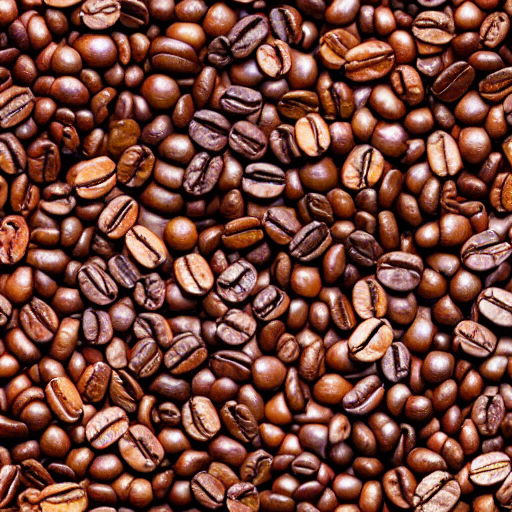

In [ ]:
import numpy as np
from PIL import Image, ImageDraw

seed = 48
prompt = "High resolution photograph of hundreds of coffee beans"

# High strength better blending, but a good chance to see a "diamond" artifact
strength = 0.50

img = seamless_diffusion(prompt, seed, strength)
display(img)

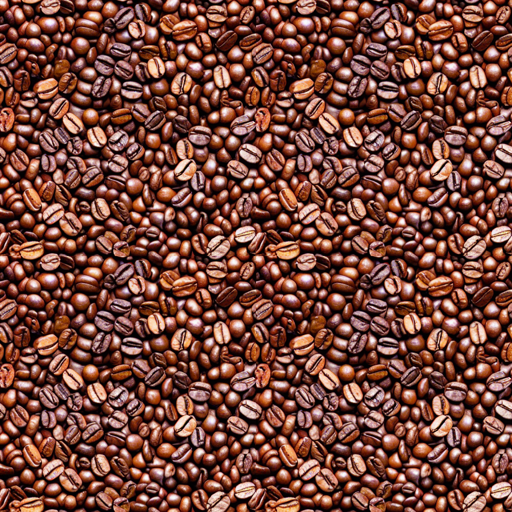

In [ ]:
# Check out how it looks like tiled 4x4
display(four_stack(img).resize((512,512)))

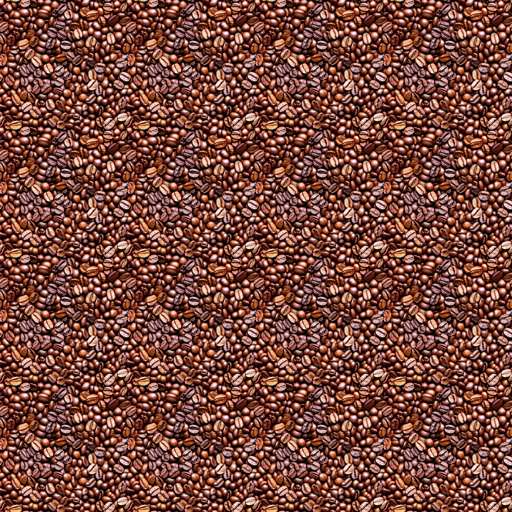

In [ ]:
# Check out how it looks like tiled 16 by 16! 
img4 = four_stack(img)
display(four_stack(img4).resize((512,512)))